## 5. 파이토치 : 단순 뉴런부터 깊은 모델 만들기

### 데이터 세트 다운로드

```
-+- train
 |    |
 |    +- Cloudy
 |    |
 |    +- Rain
 |    |
 |    +- Shine
 |    |
 |    +- Sunrise
 |
 +- test
      |
      +- Cloudy
      |
      +- Rain
      |
      +- Shine
      |
      +- Sunrise

```

In [ ]:
!git clone https://github.com/ndb796/weather_dataset
%cd weather_dataset

Cloning into 'weather_dataset'...
remote: Enumerating objects: 1117, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1117 (delta 0), reused 3 (delta 0), pack-reused 1111
Receiving objects: 100% (1117/1117), 85.23 MiB | 35.70 MiB/s, done.
/content/weather_dataset


### 라이브러리 불러오기(Load Libraries)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

### 데이터 세트 불러오기(Load Dataset)

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [5]:
train_dataset = datasets.ImageFolder(
    root='train/',
    transform=transform_train
)

dataset_size = len(train_dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

test_dataset = datasets.ImageFolder(
    root='test/',
    transform=transform_test
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

### 데이터 시각화(Data Visualization)

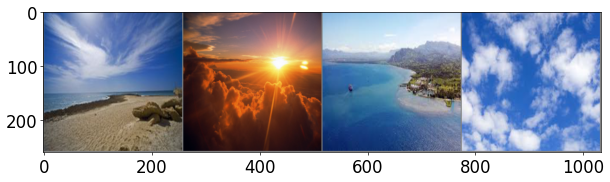

['Shine', 'Sunrise', 'Shine', 'Cloudy']


In [10]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

def imshow(input):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    plt.show()

class_names = {
  0: "Cloudy",
  1: "Rain",
  2: "Shine",
  3: "Sunrise"
}

iterator = iter(train_dataloader)

imgs, labels = next(iterator)
out = torchvision.utils.make_grid(imgs[:4])
imshow(out)
print([class_names[labels[i].item()] for i in range(4)])

### 딥러닝 모델 학습(Training)

In [9]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.linear1 = nn.Linear(256 * 256 * 3, 4)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        return x

class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.linear1 = nn.Linear(256 * 256 * 3, 64)
        self.linear2 = nn.Linear(64, 4)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.linear1 = nn.Linear(256 * 256 * 3, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.5)
        self.linear4 = nn.Linear(32, 4)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = F.relu(self.linear3(x))
        x = self.dropout3(x)
        x = self.linear4(x)
        return x

In [12]:
import time

def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [13]:
import time

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 3:
        lr /= 10
    if epoch >= 7:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

### 학습 결과 확인하기

[Epoch: 1 - Training]
train loss: 0.26212387932671444, accuracy: 0.5792592763900757
elapsed time: 8.754776000976562
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.15837490558624268, running val accuracy: 0.71875
val loss: 0.2053944345056658, accuracy: 0.692307710647583
elapsed time: 2.070220708847046
[Info] best validation accuracy!
[Epoch: 2 - Training]
train loss: 0.27446959460223164, accuracy: 0.6977777481079102
elapsed time: 7.867098331451416
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.42216378450393677, running val accuracy: 0.609375
val loss: 0.4368421904434114, accuracy: 0.6153846383094788
elapsed time: 1.6652228832244873
[Epoch: 3 - Training]
train loss: 0.21789918687608506, accuracy: 0.7259259223937988
elapsed time: 8.60522985458374
[Epoch: 3 - Validation]
[Batch: 1] running val loss: 0.22367610037326813, running val accuracy: 0.640625
val loss: 0.2206855864214474, accuracy: 0.6863905191421509
elapsed time: 1.5946686267852783
[Epoch: 4 - Training]
train loss

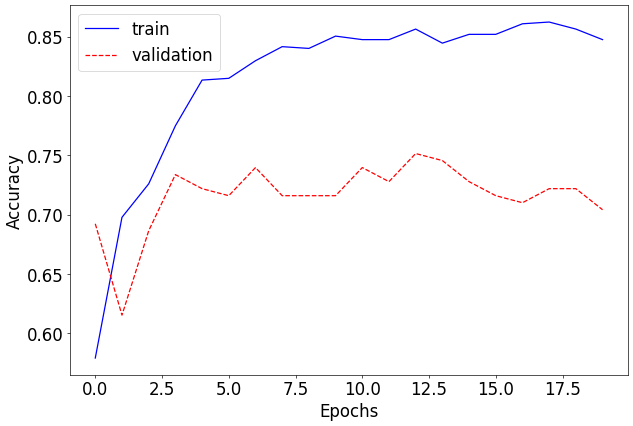

In [14]:
learning_rate = 0.01
log_step = 20

model = Model1()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Epoch: 1 - Training]
train loss: 0.11313511459915726, accuracy: 0.5155555605888367
elapsed time: 8.554644107818604
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.16004785895347595, running val accuracy: 0.453125
val loss: 0.19216044837906515, accuracy: 0.4674556255340576
elapsed time: 1.5258758068084717
[Info] best validation accuracy!
[Epoch: 2 - Training]
train loss: 0.12445836031878436, accuracy: 0.551111102104187
elapsed time: 8.598335981369019
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.09992586821317673, running val accuracy: 0.359375
val loss: 0.13503526935915974, accuracy: 0.33136093616485596
elapsed time: 1.520068645477295
[Epoch: 3 - Training]
train loss: 0.15343838727032696, accuracy: 0.5392592549324036
elapsed time: 7.693410158157349
[Epoch: 3 - Validation]
[Batch: 1] running val loss: 0.16671383380889893, running val accuracy: 0.484375
val loss: 0.22698297444179918, accuracy: 0.5147929191589355
elapsed time: 2.247018814086914
[Info] best validation accu

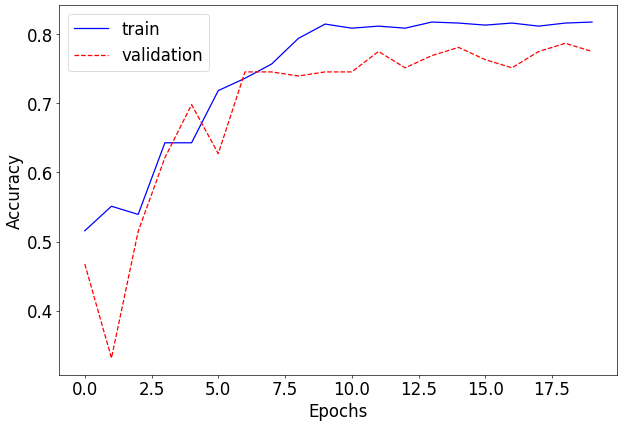

In [15]:
learning_rate = 0.01
log_step = 20

model = Model2()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Epoch: 1 - Training]
train loss: 0.020826831217165345, accuracy: 0.40444445610046387
elapsed time: 8.66435694694519
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.0139975156635046, running val accuracy: 0.546875
val loss: 0.01625732557308039, accuracy: 0.5325443744659424
elapsed time: 1.6001837253570557
[Info] best validation accuracy!
[Epoch: 2 - Training]
train loss: 0.01775085873074002, accuracy: 0.517037034034729
elapsed time: 7.9189112186431885
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.012661391869187355, running val accuracy: 0.671875
val loss: 0.01450952446672338, accuracy: 0.668639063835144
elapsed time: 2.3156936168670654
[Info] best validation accuracy!
[Epoch: 3 - Training]
train loss: 0.015582461886935763, accuracy: 0.5703703761100769
elapsed time: 7.768830299377441
[Epoch: 3 - Validation]
[Batch: 1] running val loss: 0.01181226409971714, running val accuracy: 0.671875
val loss: 0.013794436257266434, accuracy: 0.6745561957359314
elapsed time: 1.5697391

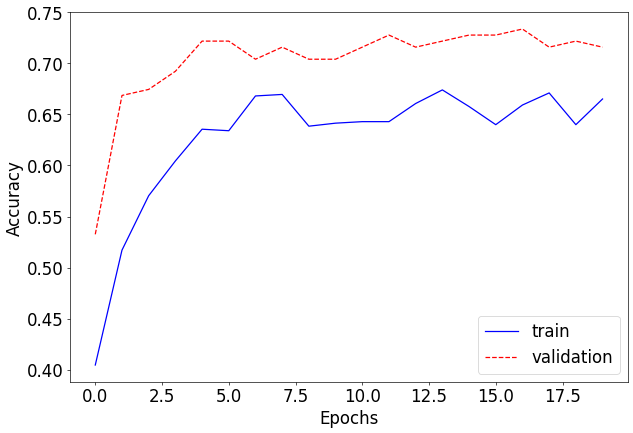

In [16]:
learning_rate = 0.01
log_step = 20

model = Model3()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")